# Creación de clase de red neuronal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# 1) Carga y partición de datos
data = pd.read_csv(".\\baseDeDatos.csv", sep=",")
X_orig = data[['T_inlet', 'MFR_inlet']].values.astype(np.float32)
Y_orig = data.iloc[:, -4:].values.astype(np.float32)

X_train_orig, X_val_orig, Y_train_orig, Y_val_orig = train_test_split(
    X_orig, Y_orig, test_size=0.152, random_state=42
)

# 2) Escalado (StandardScaler)
scaler_X = StandardScaler().fit(X_train_orig)
scaler_Y = StandardScaler().fit(Y_train_orig)

X_train = scaler_X.transform(X_train_orig).astype(np.float32)
Y_train = scaler_Y.transform(Y_train_orig).astype(np.float32)
X_val   = scaler_X.transform(X_val_orig).astype(np.float32)

# DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(scaler_Y.transform(Y_val_orig).astype(np.float32)))
train_dl = DataLoader(train_ds, batch_size=18, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=10)

# 3) Definición del modelo
class NN(nn.Module):
    def __init__(self, layers, activation='tanh'):
        super().__init__()
        activations = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
        }
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(activations[activation])
        self.net = nn.Sequential(*modules)
        # Inicialización Xavier
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# 4) Función de entrenamiento con early stopping
def fit(model, train_dl, val_dl, epochs=500, lr=1e-3, patience=30):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    wait = 0
    history = {'train_loss': [], 'val_loss': [], 'epoch': []}

    for epoch in range(1, epochs+1):
        # Entrenamiento
        model.train()
        running_train = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train += loss.item() * xb.size(0)
        train_loss = running_train / len(train_dl.dataset)

        # Validación
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                running_val += criterion(model(xb), yb).item() * xb.size(0)
        val_loss = running_val / len(val_dl.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epoch'].append(epoch)

        print(f"Epoch {epoch:03d}: Train {train_loss:.4f} — Val {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping en epoch {epoch}")
                break


    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch': history['epoch'],
          'train_losses': history['train_loss'],
          'val_losses': history['val_loss'],
          'scaler_X': scaler_X,
          'scaler_Y': scaler_Y,
    }, 'model_checkpoint05.pth')
    return history



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NN([2, 5, 5, 4], activation='tanh').to(device)

history = fit(model, train_dl, val_dl, epochs=500, lr=1e-3, patience=30)

# 5) Predicciones desescaladas
model.eval()
with torch.no_grad():
    # Validación
    X_val_tensor = torch.from_numpy(X_val).to(device)
    preds_val_scaled = model(X_val_tensor).cpu().numpy()
    preds_val = scaler_Y.inverse_transform(preds_val_scaled)

    # Conjunto completo
    X_full_scaled = scaler_X.transform(X_orig)
    X_full_tensor = torch.from_numpy(X_full_scaled.astype(np.float32)).to(device)
    preds_full_scaled = model(X_full_tensor).cpu().numpy()
    preds_full = scaler_Y.inverse_transform(preds_full_scaled)


# 6) Guardar resultados
# a) Validación
df_val = pd.DataFrame(
    np.hstack([Y_val_orig, preds_val]),
    columns=[f"Y_true_{i}" for i in range(Y_orig.shape[1])] +
            [f"Y_pred_{i}" for i in range(Y_orig.shape[1])]
)
df_val.to_csv("predicciones_validacion_desescaladas.csv", index=False)

# b) Todo el conjunto
df_full = pd.DataFrame(
    preds_full,
    columns=[f"Y_pred_full_{i}" for i in range(Y_orig.shape[1])]
)
df_full.to_csv("predicciones_completas_desescaladas.csv", index=False)

# 7) Vistazo rápido
print("Primeras 5 filas (validación):")
print(df_val.head(), "\n")
print("Últimas 5 filas (validación):")
print(df_val.tail(), "\n")
print("Primeras 5 filas (todo el conjunto):")
print(df_full.head())

Epoch 001: Train 1.0919 — Val 0.6811
Epoch 002: Train 1.0693 — Val 0.6652
Epoch 003: Train 1.0448 — Val 0.6497
Epoch 004: Train 1.0208 — Val 0.6347
Epoch 005: Train 1.0016 — Val 0.6196
Epoch 006: Train 0.9762 — Val 0.6052
Epoch 007: Train 0.9571 — Val 0.5907
Epoch 008: Train 0.9350 — Val 0.5770
Epoch 009: Train 0.9145 — Val 0.5637
Epoch 010: Train 0.8956 — Val 0.5506
Epoch 011: Train 0.8774 — Val 0.5377
Epoch 012: Train 0.8567 — Val 0.5256
Epoch 013: Train 0.8397 — Val 0.5137
Epoch 014: Train 0.8212 — Val 0.5020
Epoch 015: Train 0.8024 — Val 0.4909
Epoch 016: Train 0.7860 — Val 0.4800
Epoch 017: Train 0.7711 — Val 0.4691
Epoch 018: Train 0.7549 — Val 0.4585
Epoch 019: Train 0.7385 — Val 0.4482
Epoch 020: Train 0.7242 — Val 0.4381
Epoch 021: Train 0.7080 — Val 0.4283
Epoch 022: Train 0.6939 — Val 0.4188
Epoch 023: Train 0.6793 — Val 0.4095
Epoch 024: Train 0.6648 — Val 0.4004
Epoch 025: Train 0.6505 — Val 0.3916
Epoch 026: Train 0.6384 — Val 0.3829
Epoch 027: Train 0.6232 — Val 0.3746
E

In [ ]:
import matplotlib.ticker as ticker


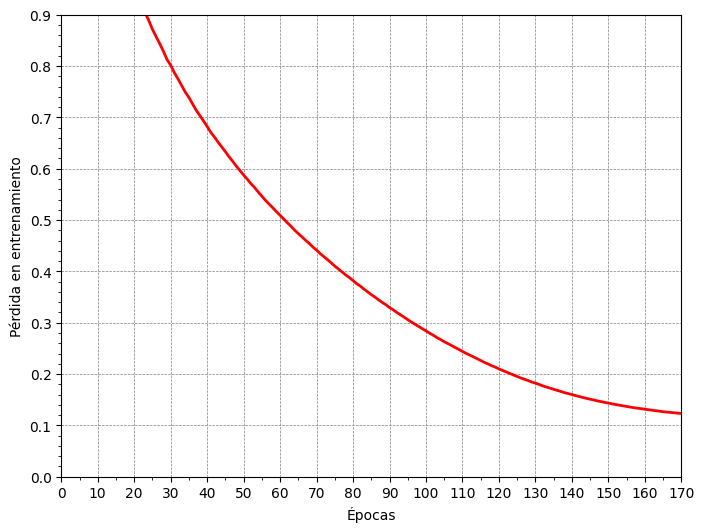

In [ ]:
fig, ax = plt.subplots(1, sharey=True, figsize=(8,6), dpi = 100)
ax.plot(history['epoch'], history['train_loss'], 'r', linewidth = 2.0)
ax.set_xlabel("Épocas")
ax.set_ylabel("Pérdida en entrenamiento")
ax.set_xlim([0, 170])
ax.set_ylim([0, 0.9])
ax.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")


ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")


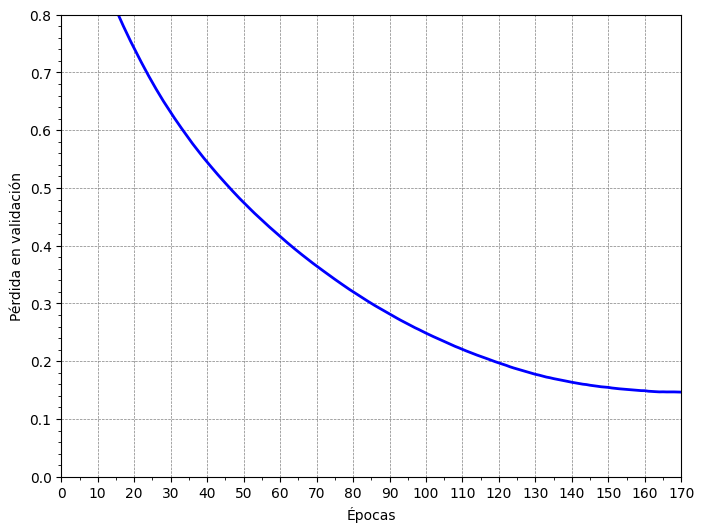

In [ ]:
fig, ax = plt.subplots(1, sharey=True, figsize=(8,6), dpi = 100)
ax.plot(history['epoch'], history['val_loss'],'b', linewidth = 2.0)
ax.set_xlabel("Épocas")
ax.set_ylabel("Pérdida en validación")
ax.set_xlim([0, 170])
ax.set_ylim([0, 0.8])

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")


In [ ]:
model.eval()
with torch.no_grad():
    X_validation = scaler_X.transform(X_val_orig).astype(np.float32)
    X_tensor = torch.from_numpy(X_validation).float()
    Y_validation = scaler_Y.transform(Y_val_orig).astype(np.float32)
    Y_tensor = torch.from_numpy(Y_validation).float()

predictions = model(X_tensor)
mse = torch.mean((predictions - Y_tensor) ** 2)
rmse = torch.sqrt(mse)

print(f'RMSE: {rmse.item()}')


RMSE: 0.38487640023231506


In [ ]:
predictions_np = predictions.detach().numpy()
predictions_unscaled = scaler_Y.inverse_transform(predictions_np)

print(predictions_unscaled)
print(X_val_orig)
print(Y_val_orig)

[[0.9063396  0.0258292  0.9582863  0.0161255 ]
 [0.9115836  0.01910435 0.95229703 0.02835109]
 [0.91020995 0.02132367 0.96016616 0.01780287]
 [0.9084544  0.02265752 0.9488924  0.0285145 ]
 [0.91112316 0.01996431 0.9561092  0.02405169]]
[[7.5e+02 8.0e-02]
 [8.5e+02 6.0e-02]
 [7.0e+02 5.0e-02]
 [9.0e+02 8.0e-02]
 [8.0e+02 6.0e-02]]
[[0.9053767  0.02580554 0.958728   0.01546646]
 [0.9097675  0.02163128 0.95092845 0.02744024]
 [0.91241205 0.02026412 0.96008474 0.01965112]
 [0.90904784 0.02362406 0.94821477 0.02816118]
 [0.9099741  0.02117642 0.95451427 0.02430932]]


In [ ]:
state_dict = torch.load('/content/model_checkpoint05.pth',weights_only=False)
print(state_dict.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'train_losses', 'val_losses', 'scaler_X', 'scaler_Y'])


In [ ]:
loadedModel = NN([2, 5, 5, 4], activation='tanh').to(device)
loadedModel.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadedModel.eval()
predictions = model(X_tensor)
mse = torch.mean((predictions - Y_tensor) ** 2)
rmse = torch.sqrt(mse)

print(f'RMSE: {rmse.item()}')

RMSE: 0.38487640023231506


In [ ]:
print(state_dict['train_losses'])

[1.407806009054184, 1.3756620287895203, 1.3439010977745056, 1.3145135641098022, 1.283989042043686, 1.2569213807582855, 1.2320296317338943, 1.207515835762024, 1.180278480052948, 1.1573616862297058, 1.1343488097190857, 1.111002653837204, 1.0903717130422592, 1.0688198804855347, 1.0473733991384506, 1.02975432574749, 1.0108998864889145, 0.9906229674816132, 0.9715026617050171, 0.9531997293233871, 0.9357434064149857, 0.920604407787323, 0.9036772102117538, 0.8885610699653625, 0.8714704066514969, 0.8572861552238464, 0.8436206132173538, 0.8287418410181999, 0.8125239759683609, 0.8017110228538513, 0.7870771735906601, 0.7751150578260422, 0.7621552050113678, 0.7491708993911743, 0.7387142404913902, 0.7264007180929184, 0.7137744501233101, 0.7036761045455933, 0.6931946128606796, 0.6823830306529999, 0.6708085015416145, 0.6616771221160889, 0.6517228484153748, 0.6424769163131714, 0.6332303658127785, 0.6232110261917114, 0.6144412979483604, 0.604945108294487, 0.5963684320449829, 0.5876103639602661, 0.579618

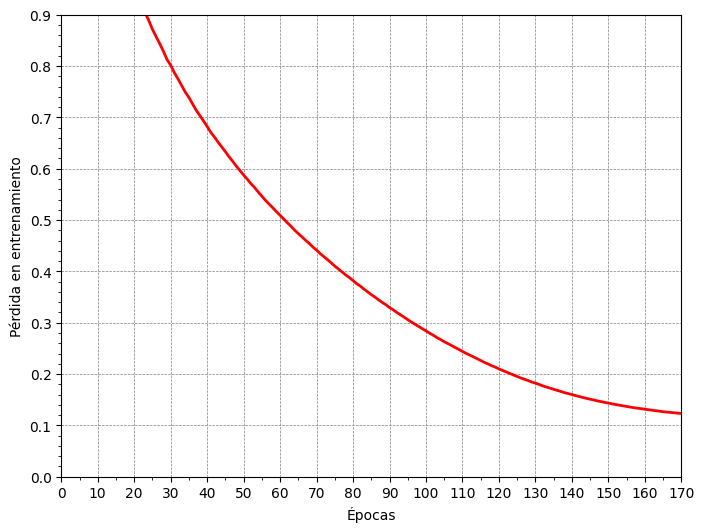

In [ ]:
fig, ax = plt.subplots(1, sharey=True, figsize=(8,6), dpi = 100)
ax.plot(state_dict['epoch'], state_dict['train_losses'], 'r', linewidth = 2.0)
ax.set_xlabel("Épocas")
ax.set_ylabel("Pérdida en entrenamiento")
ax.set_xlim([0, 170])
ax.set_ylim([0, 0.9])
ax.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")


ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")
